In [20]:
from keckdrpframework.primitives.base_primitive import BasePrimitive

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
import re

In [38]:
def create_jpg(filename):
    """
    Takes in a string filename and outputs a jpg
    """
    hdul = open_fits(filename)
    
    hdr0 = get_header(hdul)
    
    ext = np.arange(1,9)
    
    binning = get_binning(hdr0)
    
    precol, postpix, preline, postline = get_overscan(hdr0, binning)
    
    zscale = ZScaleInterval(contrast=0.06)
    vmin = None
    vmax = None
    
    alldata = []
    overscans = []
    for i in ext:
        data = hdul[i].data
        
        height, width = hdul[i].shape
        
        # get overscan regions
        overscan = get_overscan_regions(data, height, width, precol, postpix)
        overscans.append(overscan)
        
        # compute median of each overscan region - row by row
        overscan_median = overscanRegion_median(overscans)
            
        # get bias
        bias = get_bias(data, height, width, postpix)
        
        # plot bias
        bias_plots = plot_bias(bias)
        
        # bias subtraction
        data = bias_subtraction(data, bias)
        
        # get vmin and vmax
        vmin, vmax = get_minmax(data, zscale, vmin, vmax, height, width, precol, postpix, preline, postline)
        
        # remove overscan
        data = remove_overscan(data, precol, width, postpix)
        
        # append all 8 biased arrays into a list
        alldata.append(data)
    
    # plot overscan regions
#     overscan_plot = plot_overscanRegion(overscan_median)
    
    # creating CCD mosaic rows
    r0 = row0(alldata)
    r1 = row1(alldata)

    fulldata = row_stack(r0, r1)
    
    # creating jpg
    mosaic = detector_mosaic(fulldata, vmin, vmax)

In [36]:
def branch():
    """ iterate through extensions 1 - 8 """
    
    
    
    return ext

In [3]:
def open_fits(filename):
    """
    Opens the fits file
    """
    hdul = fits.open(filename)
    handled = 0
    return hdul

In [4]:
def get_header(hdul):
    """
    Gets the headers of the fits files
    """
    hdr0 = hdul[0].header
    return hdr0

In [5]:
def get_binning(hdr0):
    """
    Takes the binning dimensions
    """
    binning = hdr0['BINNING'].split(',')
    return binning

In [6]:
def get_overscan(hdr0, binning):
    """
    Gets parameters for the overscan region to compute the bias
    """
    precol =   int(hdr0['PRECOL'])   // int(binning[0])
    postpix =  int(hdr0['POSTPIX'])  // int(binning[0])
    preline =  int(hdr0['PRELINE'])  // int(binning[1])
    postline = int(hdr0['POSTLINE']) // int(binning[1])
    return precol, postpix, preline, postline

In [24]:
# def get_overscan_regions(data, height, width, precol, postpix):
#     overscan = data[0:height, width-(precol+postpix):]
#     return overscan

In [25]:
# def overscanRegion_median(overscans):
#     osr_median = []
#     for i in range(len(overscans)):
#         for row in overscans[i]:
#             med = np.median(row)
#             osr_median = np.append(osr_median, med)
#     osr_median = np.array_split(osr_median, 8)
#     return osr_median

In [37]:
def get_bias(data, height, width, postpix):
    """
    Bias is computed from the overscan region by taking the median of each column
    and then gets subtracted from the rest of the detector
    """
    x1 = 0
    x2 = height
    y1 = width - postpix
    y2 = width
    
    bias = np.median(data[x1:x2, y1:y2], axis = 1)
    bias = np.array(bias, dtype = np.int64)
    
    return bias

In [26]:
def plot_bias(bias):
    plt.plot(bias)
    plt.xlim(xmin=-500, xmax=4500)
    plt.ylim(ymin=800, ymax=2000)
    plt.xlabel('PIXEL')
    plt.ylabel('#COUNTS')
    plt.show()

In [10]:
def bias_subtraction(data, bias):
    data = data - bias[:, None]
    return data

In [11]:
def get_minmax(data, zscale, vmin, vmax, height, width, precol, postpix, preline, postline):
    """
    Get the minimum and maximum for zscaling -- not including overscan region
    """
    x1 = int(preline            + (height * 0.10))
    x2 = int(height  - postline - (height * 0.10))
    y1 = int(precol             + (width * 0.10))
    y2 = int(width - postpix    - (width * 0.10))
    tmp_vmin, tmp_vmax = zscale.get_limits(data[x1:x2, y1:y2])
    if vmin == None or tmp_vmin < vmin: vmin = tmp_vmin
    if vmax == None or tmp_vmax < vmax: vmax = tmp_vmax
    if vmin < 0: vmin = 0
    return vmin, vmax

In [12]:
def remove_overscan(data, precol, width, postpix):
    """
    Removing overscan from CCD images
    """
    data = data[:, precol: width - postpix]
    return data

In [13]:
def row0(alldata):
    """
    Creating first row of detector mosaic -- ext#: 1 - 4
    """
    r0 = np.concatenate(alldata[:4], axis=1)
    r0 = np.flipud(r0)
    return r0

In [14]:
def row1(alldata):
    """
    Creating second row of detector mosaic -- ext#: 5 - 8
    """
    r1 = []
    for arr in alldata[4:]:
        arr = np.fliplr(arr)
        r1.append(arr)
    r1 = np.concatenate(r1, axis=1)
    return r1

In [15]:
def row_stack(r0, r1):
    """
    Stacking top and bottom rows of mosaic together and rotating final image
    """
    fulldata = np.concatenate((r1, r0), axis=0)
    fulldata = np.rot90(fulldata)
    return fulldata

In [23]:
# def plot_overscanRegion(overscan_median):
    
#     fig, ax = plt.subplots(4,2, sharex=True, sharey=True)
#     fig.tight_layout(pad = 2.5)
#     ax[0,0].set_ylim([800,2000])
#     ax[0,0].plot(overscan_median[0])
#     ax[0,0].set_title('CCD1')

#     ax[1,0].set_ylim([800,2000])
#     ax[1,0].plot(overscan_median[1])
#     ax[1,0].set_title('CCD2')


#     ax[2,0].set_ylim([800,2000])
#     ax[2,0].plot(overscan_median[2])
#     ax[2,0].set_title('CCD3')

#     ax[3,0].set_ylim([800,2000])
#     ax[3,0].plot(overscan_median[3])
#     ax[3,0].set_title('CCD4')


#     ax[0,1].set_ylim([800,2000])
#     ax[0,1].plot(overscan_median[4])
#     ax[0,1].set_title('CCD5')


#     ax[1,1].set_ylim([800,2000])
#     ax[1,1].plot(overscan_median[5])
#     ax[1,1].set_title('CCD6')


#     ax[2,1].set_ylim([800,2000])
#     ax[2,1].plot(overscan_median[6])
#     ax[2,1].set_title('CCD7')


#     ax[3,1].set_ylim([800,2000])
#     ax[3,1].plot(overscan_median[7])
#     ax[3,1].set_title('CCD8')
# #     for i in range(len(overscan_median)):
# #         plt.plot(overscan_median[i])
# #         plt.xlim(xmin=-500, xmax=4500)
# #         plt.ylim(ymin=800, ymax=2000)
# #         plt.xlabel('PIXEL')
# #         plt.ylabel('#COUNTS')
# #         plt.savefig('CCD' + str(i+1), dpi=300)
#     plt.show()

In [17]:
def detector_mosaic(data, vmin, vmax):
    norm = ImageNormalize(data, vmin=vmin, vmax=vmax)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0,0,1,1])
    plt.axis('off')
    plt.imshow(data, cmap='gray', norm=norm)
#     plt.savefig(filename + '.jpg', dpi=300)
#     plt.close()
    plt.show()

##

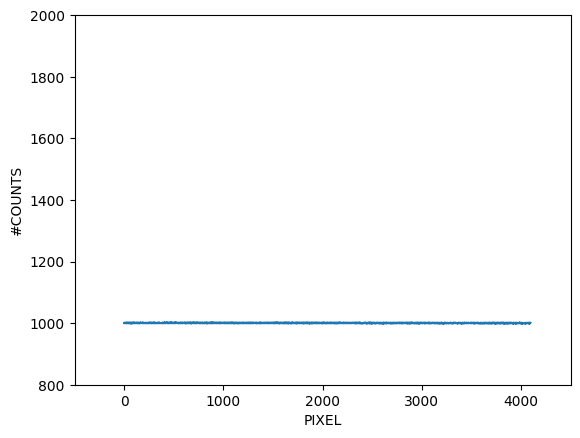

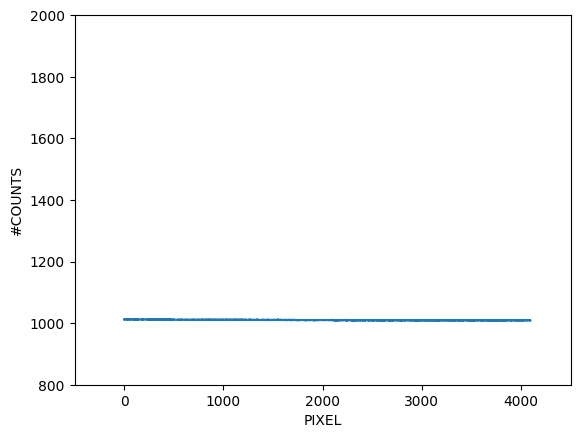

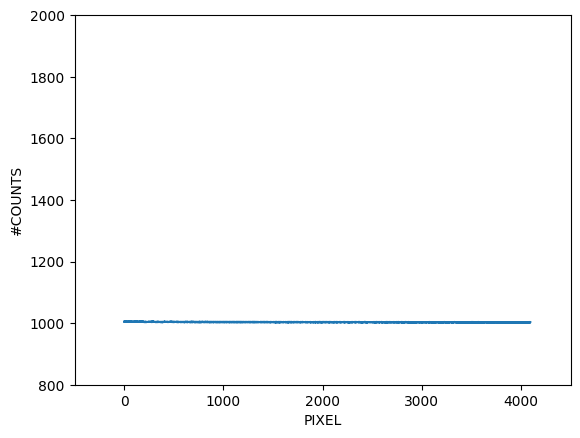

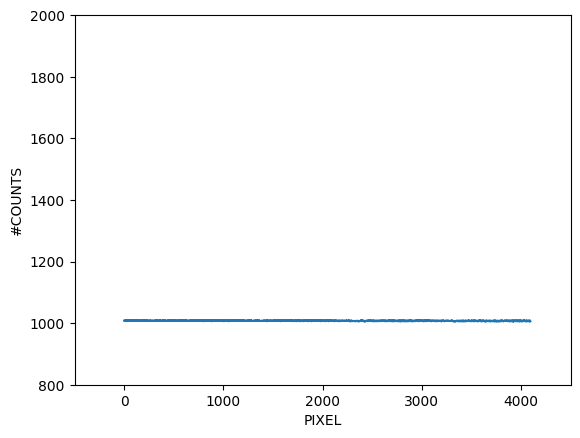

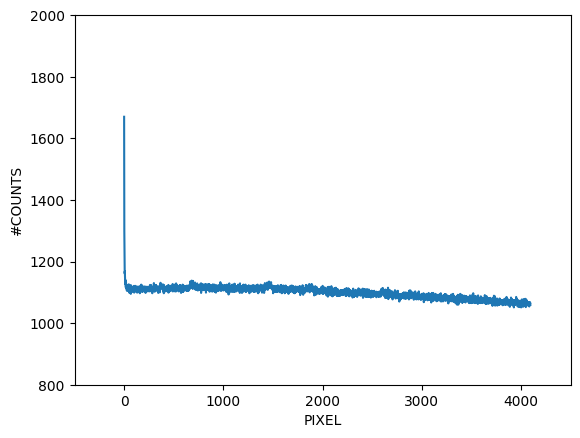

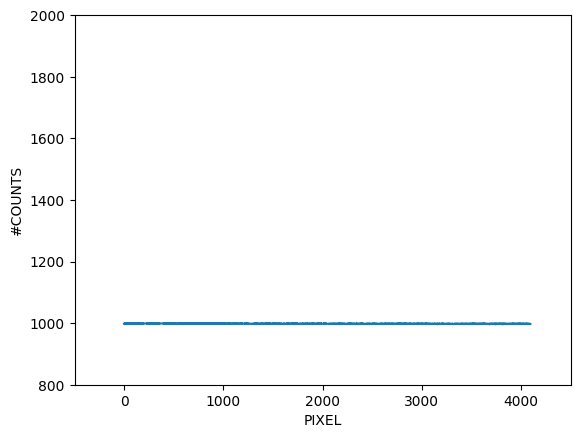

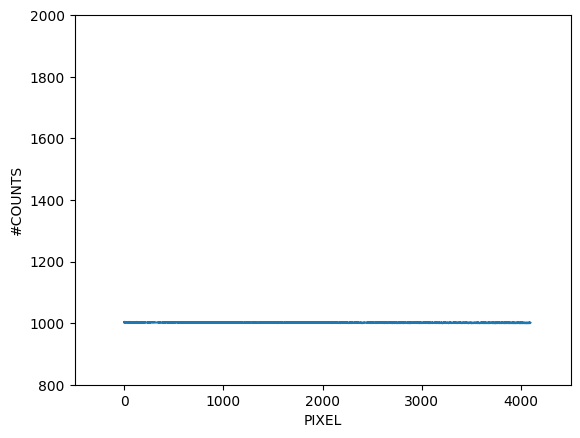

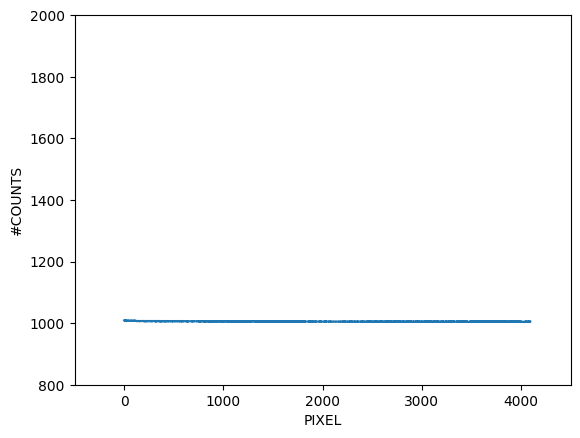

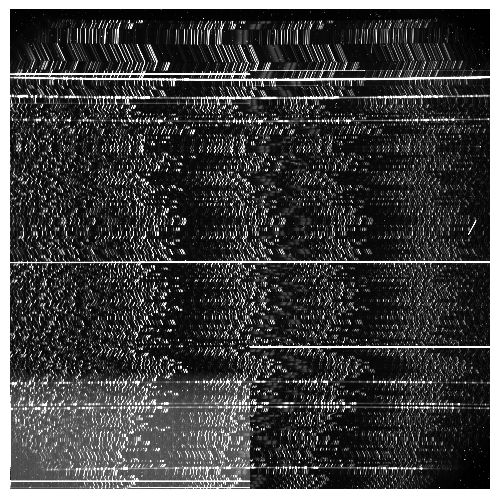

In [39]:
test = create_jpg('DE.20210602.22392.fits')

##